# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['weekday'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').weekday(), axis=1)

cleaned_rides = rides.drop(['id','timestamp','datetime','long_summary','apparentTemperatureHighTime','apparentTemperatureLowTime',
                        'apparentTemperatureLowTime','windGustTime','sunriseTime','sunsetTime','uvIndexTime','temperatureMinTime',
                        'temperatureMaxTime','apparentTemperatureMinTime','temperatureLowTime','apparentTemperatureMaxTime',
                        'latitude','longitude','temperatureMin','timezone','month','source','destination','product_id',
                        'surge_multiplier','temperature','apparentTemperature','short_summary','precipProbability','humidity',
                        'windSpeed','windGust','visibility','temperatureHigh','temperatureHighTime','temperatureLow',
                        'apparentTemperatureHigh','apparentTemperatureLow','visibility.1','ozone','moonPhase','icon','dewPoint',
                        'pressure','windBearing','cloudCover','uvIndex','temperatureMin','temperatureMax','apparentTemperatureMin',
                        'apparentTemperatureMax','day','precipIntensityMax'],axis = 1)

cat_col = ['name','weekday']
for col in cat_col:
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(cleaned_rides[[col]]).toarray())
    enc_df.columns = encoder.get_feature_names([col])
    cleaned_rides = cleaned_rides.drop(col, axis=1)
    cleaned_rides = pd.concat([cleaned_rides, enc_df], axis=1)
    
cleaned_rides = cleaned_rides.dropna(subset = ['price']).reset_index()
cleaned_rides.reset_index(drop=True, inplace=True)
cleaned_rides.insert(0,'offset',1)


uber_rides = cleaned_rides[cleaned_rides['cab_type']=='Uber']
uber_rides = uber_rides.drop('cab_type', axis=1)
lyft_rides = cleaned_rides[cleaned_rides['cab_type']=='Lyft']
lyft_rides = lyft_rides.drop('cab_type', axis=1)

y_u = uber_rides['price'].values
X_u = uber_rides.drop(columns=['price','index'],axis=1).values
X_u_train, X_u_test, y_u_train, y_u_test = train_test_split(X_u, y_u, test_size=0.1, random_state=0)
lin_reg = LinearRegression()
model_u = lin_reg.fit(X_u_train,y_u_train)
theta_u = np.append(model_u.intercept_, model_u.coef_)

y_l = lyft_rides['price'].values
X_l = lyft_rides.drop(columns=['price','index'],axis=1).values
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.1, random_state=0)
model_l = lin_reg.fit(X_l_train,y_l_train)
theta_l = np.append(model_l.intercept_, model_l.coef_)

np.random.seed(10)

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|███████████████████████████████████████████████████████████████████████| 693071/693071 [00:15<00:00, 46094.93it/s]


# Configurations

In [2]:
d_1 = len(theta_u)  # Dimension of each player's data/strategy
d_2 = len(theta_l)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

mu_p1 = -0.01*np.ones((d_1,1))
gamma_p1 = 0.01*np.ones((d_1,1))
mu_p2 = -0.01*np.ones((d_2,1))
gamma_p2 = 0.01*np.ones((d_2,1))

In [3]:
p1_data_params = (uber_rides, d_1, sigma_y_p1, mu_p1, gamma_p1, theta_u)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (lyft_rides, d_2, sigma_y_p2, mu_p2, gamma_p2, theta_l)
p2_data_generating_func = sample_from_location_family_rideshare

In [4]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_alternate_rounds = 100
num_test = 1000

# Run game with 2-stage algorithm

In [5]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_test_perf_risk_p1()
    PR2 = game_ts.evaluate_test_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if False:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1.T, gamma_p1.T)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat.T, player_one.gamma_hat.T)
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: Actual mu, gamma")
        print(mu_p2.T, gamma_p2.T)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat.T, player_two.gamma_hat.T)
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 10
num_rounds = 100
num_rounds = 1000
num_rounds = 10000
num_rounds = 100000


# Run game with DFO players

In [6]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1e-8
eta = 1e-8
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func, num_test=5)

for i in trange(num_rounds+1):
    game_dfo.theta_p1 = player_three.perturb_theta()
    game_dfo.theta_p2 = player_four.perturb_theta()
    
    PR_3_oracle = game_dfo.evaluate_test_perf_risk_p1()
    PR_4_oracle = game_dfo.evaluate_test_perf_risk_p2()
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(PR_3_oracle)
        p4_risks.append(PR_4_oracle)
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(PR_3_oracle)

            print("Player 4 risk:")
            print(PR_4_oracle)
            print("---------------------")

  0%|                                                                            | 14/100001 [00:00<1:51:00, 15.01it/s]

---------------------
Iteration 10
Player 3 risk:
2.1915633004969903
Player 4 risk:
2.6721253054677536
---------------------


  0%|                                                                           | 104/100001 [00:06<1:49:25, 15.22it/s]

---------------------
Iteration 100
Player 3 risk:
7.615217238870751
Player 4 risk:
2.6274008686425985
---------------------


  1%|▋                                                                         | 1004/100001 [01:07<1:48:25, 15.22it/s]

---------------------
Iteration 1000
Player 3 risk:
2.766678109931491
Player 4 risk:
8.103422443048657
---------------------


 10%|███████▎                                                                 | 10002/100001 [11:08<1:37:50, 15.33it/s]

---------------------
Iteration 10000
Player 3 risk:
2.8459743506858497
Player 4 risk:
5.628753826021371
---------------------


100%|████████████████████████████████████████████████████████████████████████| 100001/100001 [1:51:21<00:00, 14.97it/s]

---------------------
Iteration 100000
Player 3 risk:
0.8334815809216707
Player 4 risk:
8.567561406841362
---------------------


# Check PR for the original model

In [7]:
game_ts.theta_p1 = theta_u
game_ts.theta_p2 = theta_l

PR1_0 = game_ts.evaluate_test_perf_risk_p1()
PR2_0 = game_ts.evaluate_test_perf_risk_p2()

print(PR1_0)
print(PR2_0)

5.742032588981399
14.21470074781206


## Plots

In [8]:
# plt.figure(figsize=(10,10))
# plt.rcParams['font.size'] = 28
# plt.rcParams['axes.linewidth'] = 4

# x1 = np.array(theta_final_p1)[:,0]
# y1 = np.array(theta_final_p1)[:,1]
# plt.plot(x1,y1,
#          '--', color='#E07110', label='Algorithm 1', lw=4)

# x3 = np.insert(np.array(theta_final_p3)[:,0],0,0)
# y3 = np.insert(np.array(theta_final_p3)[:,1],0,0)
# plt.plot(x3,y3,
#          ls='dotted',label='DFO', color='#5553E6', lw=4)

# plt.legend(loc='best',fontsize=24)
# plt.xlabel(r"$\theta_1[0]$")
# plt.ylabel(r"$\theta_1[1]$")
# plt.tight_layout()
# plt.savefig('../figures/DD_regression_trajectory_steps.pdf', format='pdf')
# plt.show()

In [9]:
# plt.figure(figsize=(10,10))
# plt.rcParams['font.size'] = 28
# plt.rcParams['axes.linewidth'] = 4

# theta_3 = np.array(player_three.theta_history)
# plt.plot(theta_3[:,0],theta_3[:,1],
#          label='DFO', color='#5553E6', lw=4, zorder=5)

# x1 = np.array(theta_final_p1)[:,0]
# y1 = np.array(theta_final_p1)[:,1]
# plt.plot(x1,y1,
#          '--', color='#E07110', label='Algorithm 1', lw=4, zorder=7)

# plt.legend(loc='best',fontsize=24)
# plt.xlabel(r"$\theta_1[0]$")
# plt.ylabel(r"$\theta_1[1]$")
# plt.tight_layout()
# plt.savefig('../figures/DD_regression_trajectory.png', dpi=300, format='png')
# plt.show()

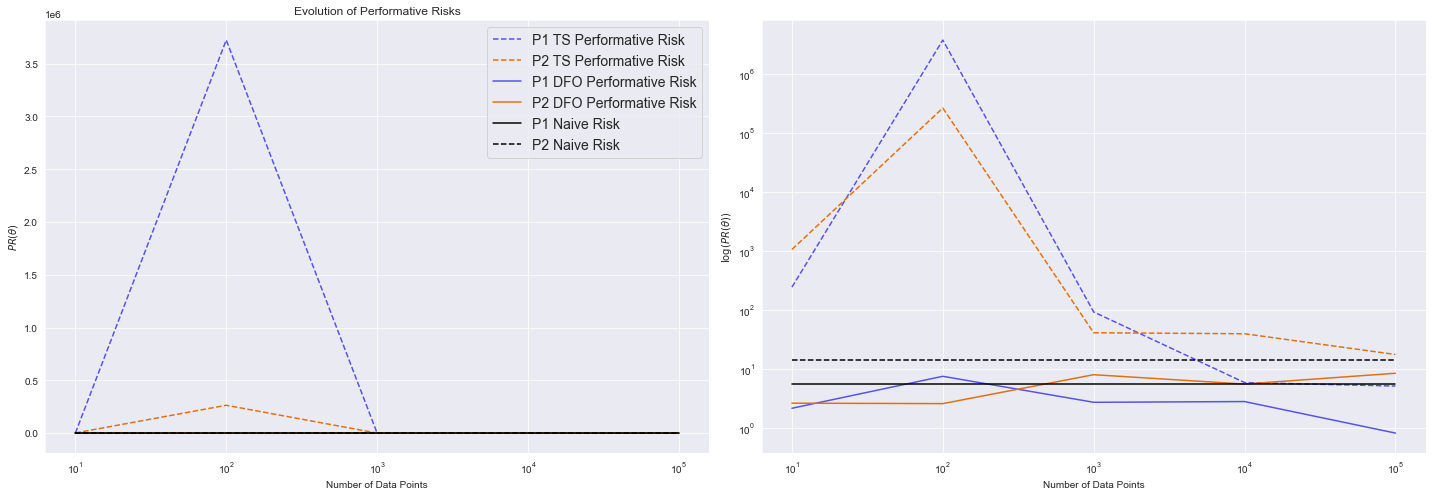

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, p1_risks,
             '--', color='#5553E6', label='P1 TS Performative Risk')
plt.semilogx(num_rounds_lst, p2_risks,
             '--', color='#E07110', label='P2 TS Performative Risk')

plt.semilogx(num_rounds_lst, p3_risks,
             '-', color='#5553E6', label='P1 DFO Performative Risk')
plt.semilogx(num_rounds_lst, p4_risks,
             '-', color='#E07110', label='P2 DFO Performative Risk')

plt.semilogx(num_rounds_lst, [PR1_0 for i in num_rounds_lst],
             '-', color='k', label='P1 Naive Risk')
plt.semilogx(num_rounds_lst, [PR2_0 for i in num_rounds_lst],
             '--', color='k', label='P2 Naive Risk') 

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Evolution of Performative Risks")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, p1_risks,
           '--', color='#5553E6', label='P1 TS Performative Risk')
plt.loglog(num_rounds_lst, p2_risks,
           '--', color='#E07110', label='P2 TS Performative Risk')

plt.loglog(num_rounds_lst, p3_risks,
           '-', color='#5553E6', label='P1 DFO Performative Risk')
plt.loglog(num_rounds_lst, p4_risks,
           '-', color='#E07110', label='P2 DFO Performative Risk')

plt.loglog(num_rounds_lst, [PR1_0 for i in num_rounds_lst],
             '-', color='k', label='P1 Naive Risk')
plt.loglog(num_rounds_lst, [PR2_0 for i in num_rounds_lst],
             '--', color='k', label='P2 Naive Risk') 

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()